In [1]:
import numpy as np
import pandas as pd
import re
import pickle
import os
import time
import urllib
import requests 
from bs4 import BeautifulSoup

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from skimage.filters import threshold_isodata
from PIL import Image
%matplotlib inline

### Scraping the letter transcripts

The Van Gogh Museum has an online archive of all of the surviving letters of Vincent van Gogh. For each letter, various information is recorded: recipient, location where the letter was written, and the date it was penned. The page for each letter also contains the transcribed and translated text of each letter as well as scanned images.  
First, I scraped the recipient, place, and date for each letter from the page listing them in chronological order. My analysis requires letters penned by the same author, so I only scraped the letters that are written by van Gogh and skipped those written to him.

In [2]:
url = 'http://vangoghletters.org/vg/letters.html'
response = requests.get(url)
webpage = response.text
soup = BeautifulSoup(webpage,'lxml')
# getting info for all letters written by Van Gogh alone, not including RM's
letter_info = []
for c in soup.find(id='searchresult').find('ul').find_all('li'):
    try:
        info = re.match('([^\s]+).*[T][o] (.*)[.] (.*?)[,] (.*)[.]',c.text)
        letid = info.group(1)
        recipient = info.group(2)
        place = info.group(3)
        date = info.group(4)
        if 'RM' not in letid:
            letter_info.append([letid, recipient, place, date])
    except: pass

letter_info = pd.DataFrame(letter_info, columns=['let_id','recipient','place','date'])

I then went to the individual urls for each letter and scraped the translated transcript text for each:

In [3]:
letter_text = []
for letid in list(letter_info.let_id):
    url = f'http://vangoghletters.org/vg/letters/let{letid}/letter.html'
    response = requests.get(url)
    webpage = response.text
    soup = BeautifulSoup(webpage,'lxml')
    paragraphs = [p.text for p in soup.find(id='letterbox1').find(class_='pagebreak').find_next_siblings(class_='p')]
    text = '\n'.join(paragraphs)
    letter_text.append([letid, text])
    time.sleep(1)
letter_info = letter_info.merge(pd.DataFrame(letter_list,columns=['let_id','transcript']), how='outer', on='let_id')

Some of the letter pages had a slightly different html structure, so I did a second round of scraping to grab those letters:

In [4]:
missing_transcripts = list(letter_info[letter_info['transcript'] == ''].let_id)
missing_text = {}
for letid in missing_transcripts:
    url = f'http://vangoghletters.org/vg/letters/let{letid}/letter.html'
    response = requests.get(url)
    webpage = response.text
    soup = BeautifulSoup(webpage,'lxml')
    paragraphs = [p.text for p in soup.find(id='letterbox1').find_all(class_='p')][1:-1]
    text = '\n'.join(paragraphs)
    missing_text[letid] = text
    time.sleep(1)
for i,row in letter_info[letter_info['let_id'].isin(missing_transcripts)].iterrows():
    letter_info.loc[i,'transcript'] = missing_text[row.let_id]

pd.DataFrame(letter_info).to_pickle('data/letter_info.pkl')

In [ ]:
letter_info = pd.read_pickle('data/letter_info.pkl')

The letter_info dataframe now contains the metadata for each letter as well as the transcript of the letter.

In [5]:
letter_info.sample(5)

,let_id,recipient,place,date,transcript
557,583,Theo van Gogh,Arles,"Friday, 9 March 1888","My dear Theo,\nNow at long last, this morning ..."
746,816,Theo van Gogh,Saint-Rémy-de-Provence,"on or about Sunday, 3 November 1889","My dear Theo,\nEnclosed I’m sending you a list..."
334,342,Theo van Gogh,The Hague,"on or about Thursday, 10 May 1883","My dear Theo,\nI received your letter in good ..."
158,162,Theo van Gogh,Brussels,January 1881,"Brussels, January 81.\nMy dear Theo,\nYou will..."
262,270,Theo van Gogh,The Hague,"on or about Sunday, 1 October 1882","My dear Theo,\nJust a word to say that your le..."


### Downloading the scanned letters

The scanned images were not directly embedded in the html file, so I found and downloaded a zip of the xml files from the museum website which contained the appropriate urls for each image. First, I created a list of the downloaded xml filenames.

In [6]:
%ls data/xml/ > data/xml_filenames.txt
with open('data/xml_filenames.txt','r') as f:
    xml_filenames = f.readlines()
    xml_filenames = [f.strip() for f in xml_filenames]

To then save the images, I parsed the xml files to get the urls and downloaded each image.

In [7]:
for f in xml_filenames:
    letid = re.match('[l][e][t](.*)[.]',f).group(1) # getting the numerical letid from the filename
    if letid in list(letter_info.let_id):
        i = 1
        with open(f'data/xml/{f}', 'r') as file:
            text = file.readlines()
        for line in text:
            if 'image/png' in line: # want to grab the images as pngs (highest resolution) out of the xml file
                end = re.match('.*image\/png" url="(.*?)["]',line).group(1)
                url = 'http://vangoghletters.org/vg/facsimiles/' + end
                urllib.request.urlretrieve(url, f'data/scanned_letters/{letid}_0{i}.png') 
                i += 1

### Image preprocessing

#### Manual preprocessing

Some of the scanned letters contained blank pages or pages dominated by sketches. Since I wanted the neural network to detect features of handwriting, I manually removed these (moved to 'data/scanned_images/blank_sketches') or cropped sketches out.  
I also cropped the letterhead out of some letters because I didn't want the neural network finding similar features in letters just due to a common stationery. 

#### Image thresholding

In order to reduce the information being processed by the autoencoder (to eliminate variations from dark spots in stationery etc), I performed a series of prepocessing steps using the PILLOW and scikit image libraries.  
I converted each image to grayscale, resized to a uniform size, and then used adaptive thresholding to convert all images to a binary form and remove the background.

Here is a before and after of the thresholding:

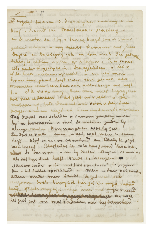

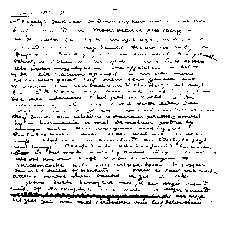

In [8]:
img = Image.open('data/scanned_letters/cleaned_cropped/288_05.png')
plt.imshow(img, cmap=cm.gray)
plt.axis('off')
plt.show()

img = img.convert('L')
img = img.resize((256,256))
img = np.asarray(img)
thresh = threshold_isodata(img)
binary = (img >= thresh).astype('int')

plt.imshow(binary, cmap=cm.gray)
plt.axis('off')
plt.show()

In [9]:
thresholded_imgs = []
for file in os.listdir('data/scanned_letters/cleaned_cropped'):
    if file[0] != '.':
        img = Image.open('data/scanned_letters/cleaned_cropped/' + file)
        file = file.split('.')[0]          # remove the extension from the file name
        img = img.convert('L')
        img = img.resize((256,256))
        img = np.asarray(img)
        thresh = threshold_isodata(img)
        binary = (img >= thresh).astype('int')
        thresholded_imgs.append([file,binary]) # saving the letid and binary np array of each img

thresholded_imgs = np.array(thresholded_imgs)      # convert list of lists to np array

with open('data/thresholded_imgs.pkl','wb') as f:  # pickle the numpy array
    pickle.dump(thresholded_imgs, f)

In [10]:
with open('data/thresholded_imgs.pkl','rb') as f:
    thresholded_imgs = pickle.load(f)

In [11]:
pd.DataFrame(thresholded_imgs).sample(5)

,0,1
1463,589_03,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
253,535_02,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1238,765_02,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1962,377_02,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
406,823_01,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


Now each image is a 256x256 np array

In [12]:
pd.DataFrame(thresholded_imgs).loc[0,1].shape

(256, 256)